In [1]:
%load_ext autoreload
%autoreload 2

import gc
import cv2
import PIL
import random
import numpy as np
import os
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pdb
from dataclasses import dataclass
from functools import partial

from skimage.morphology import label
from sklearn.model_selection import KFold

from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.nn.functional import binary_cross_entropy_with_logits
import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, Sampler

from fastai.vision.data import SegmentationItemList, SegmentationLabelList, ImageList, imagenet_stats
from fastai.data_block import FloatList, FloatItem
from fastai.basic_data import DatasetType
from fastai.basic_train import Learner
from fastai.callback import OptimWrapper
from fastai.vision.image import Image, ImageSegment, image2np, pil2tensor
from fastai.vision.transform import get_transforms
from fastai.vision.learner import unet_learner, cnn_learner
import fastai.vision.models as mod
from fastai.callbacks import SaveModelCallback, LearnerCallback
from fastai.metrics import accuracy

from pathlib import Path

# IMAGE SIZES
TRAIN_SIZE = 256
MAX_SIZE = 1388
TEST_SIZE = 224
TEST_OVERLAP = 64
IMG_CHANNELS = 3

# PATHS
PROJECT_PATH = Path(
    '/work/stages/schwob/siim-pneumothorax')
FULL_TRAIN_PATH = PROJECT_PATH/'data/dicom-images-train'
FULL_TEST_PATH = PROJECT_PATH/'data/dicom-images-test'
DATA = PROJECT_PATH/'data'
TRAIN_PATH = PROJECT_PATH/'data/train'
TEST_PATH = PROJECT_PATH/'data/test'
MODELS_PATH = PROJECT_PATH/'models/'
SUB_PATH = PROJECT_PATH/'submissions/'
LABELS_OLD = PROJECT_PATH/'data/train-rle.csv'
LABELS = PROJECT_PATH/'data/train-rle-fastai2.csv'
LABELS_POS = PROJECT_PATH/'data/train-rle-fastai_pos.csv'
LABELS_CLASSIF = PROJECT_PATH/'data/train-rle-fastai-classif.csv'
LOG = Path('/work/stages/schwob/runs')

# LEARNER CONFIG
BATCH_SIZE = 16
WD = 0.1
LR = 2e-4
GROUP_LIMITS = None
FREEZE_UNTIL = None
EPOCHS = 10
UNFROZE_EPOCHS = 10
PRETRAINED = True
MODEL = 'resnet34'
CLASSES = ['pneum']
ACT = 'sigmoid'

In [2]:
from fastai.vision.models.xresnet2 import xresnet34_2, xresnet50_2, xresnet101, xresnet152

In [3]:
models = {
    'resnet34': mod.resnet34, 'resnet50': mod.resnet50,
    'resnet101': mod.resnet101, 'resnet152': mod.resnet152,
    'xresnet34': xresnet34_2, 'xresnet50': xresnet50_2,
    'xresnet101': xresnet101, 'xresnet152': xresnet152}

In [4]:
def getNextFilePath(output_folder, base_name):
    highest_num = 0
    for f in output_folder.iterdir():
        if f.is_file():
            try:
                f = str(f.with_suffix('').name)
                if f.split('_')[:-1] == base_name.split('_'):
                    split = f.split('_')
                    file_num = int(split[-1])
                    if file_num > highest_num:
                        highest_num = file_num
            except ValueError:
                'The file name "%s" is incorrect. Skipping' % f

    output_file = highest_num + 1
    return output_file

In [5]:
def restruct(src, dest):
    for fn in src.glob('**/*dcm'):
        ds = pydicom.dcmread(str(fn))
        pydicom.dcmwrite(str(dest/fn.name), ds)

In [6]:
#restruct(FULL_TRAIN_PATH, TRAIN_PATH)

In [7]:
#restruct(FULL_TEST_PATH, TEST_PATH)

In [8]:
def change_csv(old, new, path):
    df = pd.read_csv(old, sep=', ')
    new_df = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])
    for row in df.itertuples():
        image_id = row.ImageId
        label = row.EncodedPixels
        image_id = Path(path.name)/(image_id+'.dcm')
        new_df.loc[row.Index] = [image_id, label]
    new_df.to_csv(new, index=False)

In [9]:
#change_csv(LABELS_OLD, LABELS, TRAIN_PATH)

In [10]:
df = pd.read_csv(LABELS, header='infer')
df.head()

,ImageId,EncodedPixels
0,train/1.2.276.0.7230010.3.1.4.8323329.5597.151...,-1
1,train/1.2.276.0.7230010.3.1.4.8323329.12515.15...,-1
2,train/1.2.276.0.7230010.3.1.4.8323329.4904.151...,175349 7 1013 12 1009 17 1005 19 1003 20 1002 ...
3,train/1.2.276.0.7230010.3.1.4.8323329.32579.15...,162376 12 1007 18 1003 22 999 26 996 28 993 30...
4,train/1.2.276.0.7230010.3.1.4.8323329.1314.151...,119331 47 972 82 937 107 912 122 897 137 882 1...


In [11]:
df.shape

(10675, 2)

In [12]:
df['ImageId'].unique().shape

(10675,)

In [13]:
def absol2relat(rle):
    if rle == '-1': return '-1'
    pixels = rle.split()
    new_rle = []
    cur = 0
    for k in range(0, len(pixels), 2):
        if k==0:
            new_rle.append(pixels[k])
            new_rle.append(pixels[k+1])
        else:
            cur = int(pixels[k])
            prev = int(pixels[k-2])+int(pixels[k-1])
            new_rle.append(str(cur-prev))
            new_rle.append(pixels[k+1])
    return ' '.join(new_rle)

In [14]:
def relat2absol(rle):
    if rle == '-1': return '-1'
    pixels = rle.split()
    new_rle = []
    cur = 0
    for k in range(0, len(pixels), 2):
        pix = pixels[k]
        cur += int(pix)
        length = pixels[k+1]
        new_rle.append(str(cur))
        new_rle.append(length)
        cur += int(length)
    return ' '.join(new_rle)

In [15]:
def merge_rles(rle1, rle2):
    if rle1 == rle2: return rle1
    i1 = 0
    i2 = 0
    rle = []
    pixels1 = relat2absol(rle1).split()
    pixels2 = relat2absol(rle2).split()
    while i1<len(pixels1) and i2<len(pixels2):
        p1 = int(pixels1[i1])
        l1 = int(pixels1[i1+1])
        p2 = int(pixels2[i2])
        l2 = int(pixels2[i2+1])
        if p1<=p2: 
            rle.append(str(p1))
            if p2<=p1+l1-1:
                rle.append(str(max(p2-p1+l2, l1)))
                i2 += 2
            else:
                rle.append(str(l1))
            i1 += 2
        else: 
            rle.append(str(p2))
            if p1<=p2+l2-1:
                rle.append(str(max(p1-p2+l1, l2)))
                i1 += 2
            else:
                rle.append(str(l2))
            i2 += 2
            
    rle += pixels1[i1:]+pixels2[i2:]
    return absol2relat(' '.join(rle))

In [16]:
def merge_doubles(old, new):
    df = pd.read_csv(old)
    new_df = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])
    for k, id in enumerate(df['ImageId'].unique()):
        new_rle = ''
        for rle in df.loc[df['ImageId']==id, 'EncodedPixels']:
            new_rle = merge_rles(new_rle, rle)
        new_df.loc[k] = [id, new_rle]
    new_df.to_csv(new, index=False)

In [17]:
#merge_doubles(PROJECT_PATH/'data/train-rle-fastai.csv', PROJECT_PATH/'data/train-rle-fastai2.csv')

In [18]:
def keep_pos(old, new):
    df = pd.read_csv(old)
    new_df = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])
    for row in df.itertuples():
        id = row.ImageId
        rle = row.EncodedPixels
        k = row.Index
        if rle != '-1' or random.random() <= 0.2:
            # keep all postive and only 20% of negative for segmentation
            new_df.loc[k] = [id, rle]
    new_df.to_csv(new, index=False)

In [19]:
#keep_pos(LABELS, LABELS_POS)

In [20]:
def create_classif_csv(old, new):
    df = pd.read_csv(old)
    new_df = pd.DataFrame(columns=['ImageId', 'Labels'])
    for row in df.itertuples():
        image_id = row.ImageId
        rle = row.EncodedPixels
        new_df.loc[row.Index] = [image_id, 1 if rle!='-1' else 0]
    new_df.to_csv(new, index=False)

In [21]:
#create_classif_csv(LABELS, LABELS_CLASSIF)

In [22]:
def open_image(fn):
    return pydicom.dcmread(str(fn)).pixel_array

def show(img, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.bone)
    plt.show()

In [23]:
def show_dcm_info(fn):
    dataset = pydicom.dcmread(str(fn))
    print("Filename.........:", fn)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

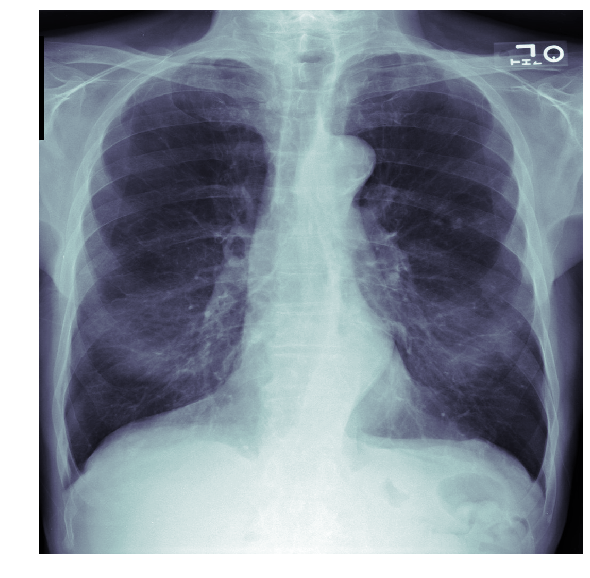

In [24]:
fn = next(TRAIN_PATH.glob('**/*.dcm'))
img = open_image(fn)
show(img)

In [25]:
show_dcm_info(fn)

Filename.........: /work/stages/schwob/siim-pneumothorax/data/train/1.2.276.0.7230010.3.1.4.8323329.14243.1517875250.398380.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: eff52c22-7c7b-4c6f-9173-671c2ad56a1f, 
Patient id..........: eff52c22-7c7b-4c6f-9173-671c2ad56a1f
Patient's Age.......: 79
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 144656 bytes
Pixel spacing....: ['0.171', '0.171']


In [26]:
img.shape

(1024, 1024)

In [27]:
def mask2rle(img, width, height):
    rle = []
    lastColor = 0
    currentPixel = 0
    runStart = -1
    runLength = 0

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel
                    runLength = 1
                else:
                    rle.append(str(runStart))
                    rle.append(str(runLength))
                    runStart = -1
                    runLength = 0
                    currentPixel = 0
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor
            currentPixel += 1

    return " ".join(rle)

In [28]:
def rle2mask(rle, width, height):
    if rle == '-1':
        return np.zeros((width, height))
    mask = np.zeros(width * height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height).T

In [29]:
class PneumoSegmentationList(SegmentationItemList):
    def open(self, fn):
        x = open_image(fn)
        x = pil2tensor(x, np.float32)
        x = torch.cat((x, x, x))
        return Image(x/255)

In [30]:
class ImageSegmentFloat(ImageSegment):
    @property
    def data(self):
        return self.px.float()

In [31]:
class MaskList(SegmentationLabelList):
    def __init__(self, *args, train_path=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.train_path = train_path
        
    def open(self, fn):
        assert self.train_path, "a path for train set must be specified"
        img_path = fn[0]
        rle = fn[1]
        h, w = open_image(self.train_path/img_path).shape
        y = rle2mask(rle, w, h)
        y = pil2tensor(y, np.float32)
        return ImageSegmentFloat(y/255)
    
    def analyze_pred(self, pred, thresh: float = 0.5):
        if torch.min(pred).item()<0 or torch.max(pred).item()>1:
            pred = torch.sigmoid(pred)
        return (pred > thresh).float()
    
    def reconstruct(self, t):
        return ImageSegmentFloat(t.float())

In [32]:
class PneumoClassifList(ImageList):
    def open(self, fn):
        x = open_image(fn)
        x = pil2tensor(x, np.float32)
        x = torch.cat((x, x, x))
        return Image(x/255)

In [33]:
def get_weights(train_list):
    df = train_list.inner_df
    n_tot = df.shape[0]
    df = df.reindex(index=range(n_tot), method='bfill')
    class_weights = []
    weights = np.zeros(n_tot)    
    for c in train_list.classes:
        w = df.loc[df['Labels']==c].shape[0]/n_tot
        w = (1-w)/(train_list.c-1)
        class_weights.append(w)
        weights[df.loc[df['Labels']==c].index.values] = w
    return weights, class_weights

In [34]:
def create_sampler(train_list, class_weights):
    weights = [class_weights[c.data] for _, c in train_list.train]
    sampler = WeightedRandomSampler(weights, len(weights))
    return sampler

In [35]:
def load_data(path, bs=8, train_size=256):
    train_list = (PneumoSegmentationList.
                  from_csv(path.parent, path.name).
                  split_by_rand_pct(valid_pct=0.2).
                  label_from_df(cols=[0, 1], classes=['pneum'], label_cls=MaskList, train_path=path.parent).
                  transform(get_transforms(), size=train_size, tfm_y=True).
                  databunch(bs=bs, num_workers=0).
                  normalize(imagenet_stats))
    return train_list

In [36]:
def load_data_classif(path, bs=8, train_size=256, weight_sample=True):
    train_list = (PneumoClassifList.
                  from_csv(path.parent, path.name).
                  split_by_rand_pct(valid_pct=0.2).
                  label_from_df().
                  transform(get_transforms(), size=train_size))
    if weight_sample:
        weights, class_weights = get_weights(train_list)
        sampler = WeightedRandomSampler(weights, len(weights))
        
    train_list = train_list.databunch(bs=bs, num_workers=0).normalize(imagenet_stats)
    
    if weight_sample:
        train_list.train_dl = train_list.train_dl.new(shuffle=False, sampler=sampler)
        return train_list, class_weights
    
    return train_list, None

In [37]:
db = load_data(LABELS, bs=BATCH_SIZE, train_size=TRAIN_SIZE)

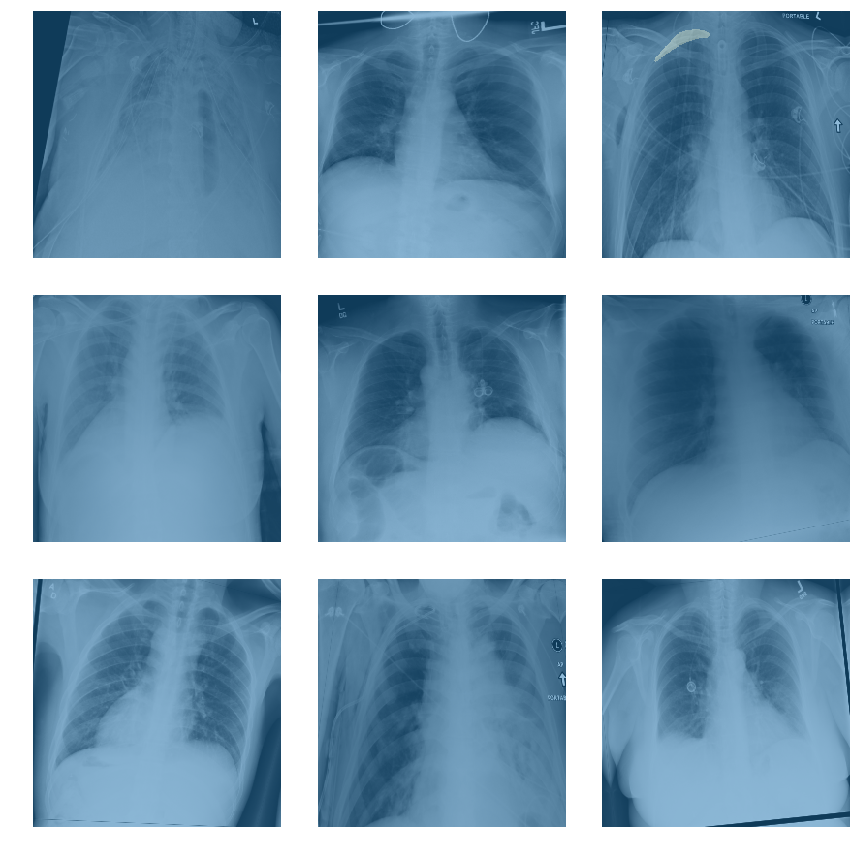

In [38]:
db.show_batch(rows=3, cmap=plt.cm.bone)

In [39]:
def dice(input, target, thr=0.2, smooth=1., reduction='mean'):
    assert input.shape==target.shape, "input and target must have same shape"
    iflat = torch.sigmoid(input).view(input.size(0), -1)
    if thr: iflat = (iflat>thr).float()
    tflat = target.view(target.size(0), -1)
    intersection = (iflat * tflat).sum(-1)
    dice = (2. * intersection + smooth)/(iflat.sum(-1) + tflat.sum(-1) + smooth)
    if reduction=='mean':
        return dice.mean()
    elif reduction=='sum':
        return dice.sum()
    else:
        return dice

In [40]:
def dice_loss(input, target, **kwargs):
    return 1-dice(input, target, **kwargs)

In [41]:
def bce_loss(input, target, reduction='mean', beta=None):
    n = input.size(0)
    iflat = torch.sigmoid(input).view(n, -1)
    tflat = target.view(n, -1)
    if not beta:
        beta = 0.5
    bce = -2*(beta*tflat*iflat.log()+(1-beta)*(1-tflat)*(1-iflat).log()).mean(-1)
    if reduction == 'mean':
        return bce.mean()
    elif reduction == 'sum':
        return bce.sum()
    else:
        return bce

In [42]:
def bce_dice_loss(input, target, a=0.5, b=0.5, smooth=1., thr=None, beta=None, reduction='mean', **kwargs):
    dice =  dice_loss(input, target, smooth=smooth, thr=thr, reduction=reduction, **kwargs)
    bce = bce_loss(input, target, beta=beta, reduction=reduction, **kwargs)
    return a*dice+b*bce

In [43]:
@dataclass
class URLoss():
    func : nn.Module
    loss : torch.Tensor = None
    reduction : str = 'mean'
    
    def __post_init__(self):
        self.func.reduction = 'none'
        
    def __call__(self, input, target):
        self.func.reduction = 'none'
        self.loss = self.func(input, target)
        if self.reduction == 'mean': return self.loss.mean()
        elif self.reduction == 'sum': return self.loss.sum()
        else: return self.loss
        
    def __getattr__(self, name):
        return getattr(self.func, name)
    
    def __setstate__(self, data): 
        self.__dict__.update(data)

In [44]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1., reduction='mean'):
        super().__init__()
        self.smooth = smooth
        self.reduction = reduction
    
    def forward(self, input, target):
        return dice_loss(input, target, smooth=self.smooth, thr=None, reduction=self.reduction)

In [45]:
class BCELoss(nn.Module):
    def __init__(self, beta=None, reduction='mean'):
        super().__init__()
        self.beta = beta
        self.reduction = reduction
        
    def forward(self, input, target):
        return bce_loss(input, target, reduction=self.reduction, beta=self.beta)

In [46]:
class BCEDiceLoss(nn.Module):
    def __init__(self, a=0.5, b=0.5, smooth=1., beta=None, reduction='mean'):
        super().__init__()
        self.a = a
        self.b = b
        self.smooth = smooth
        self.beta = beta
        self.reduction = reduction
        
    def forward(self, input, target, **kwargs):
        return bce_dice_loss(input, target, a=self.a, b=self.b, smooth=self.smooth, thr=None, beta=self.beta, reduction=self.reduction)

In [47]:
from itertools import tee
def new_iter(self):
    dl = iter(self.dl)
    dl.sample_iter, self.sample_iter = tee(dl.sample_iter)
    for b in dl:
        yield self.proc_batch(b)

from fastai.basic_data import DeviceDataLoader
DeviceDataLoader.__iter__= new_iter

In [48]:
class RandomSampler(Sampler):
    def __init__(self, num_samples, weights = None):
        self.weights = weights if weights is not None else torch.ones(num_samples)
        self.to_update = torch.ones_like(self.weights, dtype=torch.bool)
        self.num_samples = num_samples

    def __iter__(self):
        return iter(torch.multinomial(self.weights, self.num_samples, True).tolist())

    def __len__(self):
        return self.num_samples

In [49]:
class UpdateSamplerCallback(LearnerCallback):
    _order = 0
    def on_epoch_end(self, **kwargs):
        sampler = self.learn.data.train_dl.sampler
        sampler.weights[sampler.to_update] += 0.2
        sampler.weights = torch.clamp(sampler.weights, 0., 1.)
        sampler.to_update = torch.ones_like(sampler.weights, dtype=torch.bool)
        
    def on_backward_begin(self, **kwargs):
        loss = self.learn.loss_func.loss
        dl = self.learn.data.train_dl
        idxs = next(dl.sample_iter)
        dl.sampler.weights[idxs] = 1-torch.exp(-loss.cpu().detach())
        dl.sampler.to_update[idxs] = False

In [50]:
class AccumulateOptimWrapper(OptimWrapper):
    def step(self):           pass
    def zero_grad(self):      pass
    def real_step(self):      super().step()
    def real_zero_grad(self): super().zero_grad()
        
def acc_create_opt(self, lr, wd=0.):
        "Create optimizer with `lr` learning rate and `wd` weight decay."
        self.opt = AccumulateOptimWrapper.create(self.opt_func, lr, self.layer_groups,
                                         wd=wd, true_wd=self.true_wd, bn_wd=self.bn_wd)
Learner.create_opt = acc_create_opt   

In [51]:
@dataclass
class AccumulateStep(LearnerCallback):
    """
    Does accumlated step every nth step by accumulating gradients
    """
    def __init__(self, learn:Learner, n_step:int = 1):
        super().__init__(learn)
        self.n_step = n_step

    def on_epoch_begin(self, **kwargs):
        "init samples and batches, change optimizer"
        self.acc_batches = 0
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        "accumulate samples and batches"
        self.acc_batches += 1
        
    def on_backward_end(self, **kwargs):
        "step if number of desired batches accumulated, reset samples"
        if (self.acc_batches % self.n_step) == self.n_step - 1:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_batches)
    
            self.learn.opt.real_step()
            self.learn.opt.real_zero_grad()
            self.acc_batches = 0
    
    def on_epoch_end(self, **kwargs):
        "step the rest of the accumulated grads"
        if self.acc_batches > 0:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_batches)
            self.learn.opt.real_step()
            self.learn.opt.real_zero_grad()
            self.acc_batches = 0

In [52]:
def set_BN_momentum(model,momentum=0.05):
    for layer in model.modules():
        if isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.BatchNorm1d):
            layer.momentum = momentum

In [53]:
clf_name = f'backbone_clf_{MODEL}'
clf_name = f'{clf_name}_{getNextFilePath(MODELS_PATH, clf_name)-1}.pth'
clf_name

'backbone_clf_resnet34_0.pth'

In [54]:
save_name = f'seg_{MODEL}'
save_name = f'{save_name}_{getNextFilePath(MODELS_PATH, save_name)-1}'
save_name

'seg_resnet34_3'

In [55]:
learner = unet_learner(db, models[MODEL], pretrained=PRETRAINED, loss_func=URLoss(BCEDiceLoss(a=0.5, b=0.5, beta=0.7, smooth=0.1)),
                       wd=WD, model_dir=MODELS_PATH, metrics=[partial(dice, smooth=0.1)])

In [56]:
next(learner.model.children())[0].load_state_dict(torch.load(MODELS_PATH/clf_name))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [57]:
learner = learner.to_fp16()

In [102]:
learner.lr_find(num_it=200)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


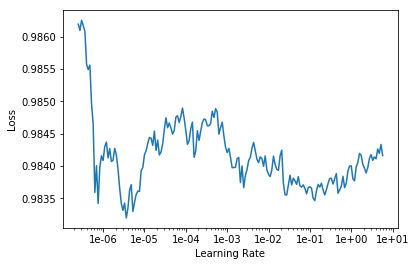

In [67]:
learner.recorder.plot()

In [91]:
learner.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [103]:
LR = 1e-3

In [104]:
sampler = RandomSampler(len(db.train_ds))

In [105]:
learner.data.train_dl = db.train_dl.new(shuffle=False, sampler=sampler)

In [106]:
set_BN_momentum(learner.model)

In [107]:
learner.fit_one_cycle(
    10, slice(LR),
    callbacks=[
        SaveModelCallback(
            learner, monitor='dice', name=save_name),
        UpdateSamplerCallback(learner),
        AccumulateStep(learner, 64//BATCH_SIZE)])

epoch,train_loss,valid_loss,dice,time
0,0.151541,0.128207,0.790236,09:36
1,0.231813,0.189993,0.730936,09:04
2,0.287068,0.132243,0.791867,08:51
3,0.231833,0.105995,0.819225,08:27
4,0.256951,0.126217,0.790236,08:36
5,0.241879,0.119255,0.787128,08:29
6,0.189808,0.107601,0.811035,08:24
7,0.201992,0.105148,0.814031,08:34
8,0.188728,0.104050,0.814858,09:00
9,0.185899,0.103645,0.815783,08:56


Better model found at epoch 0 with dice value: 0.7902362942695618.
Better model found at epoch 2 with dice value: 0.7918673157691956.
Better model found at epoch 3 with dice value: 0.8192253708839417.


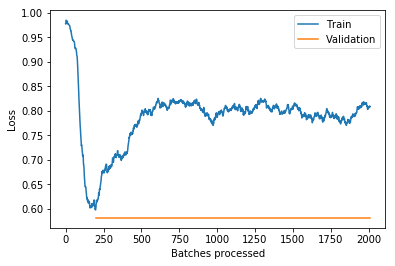

In [73]:
learner.recorder.plot_losses()

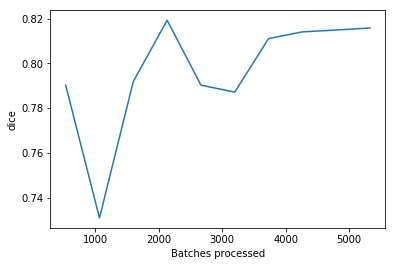

In [108]:
learner.recorder.plot_metrics()

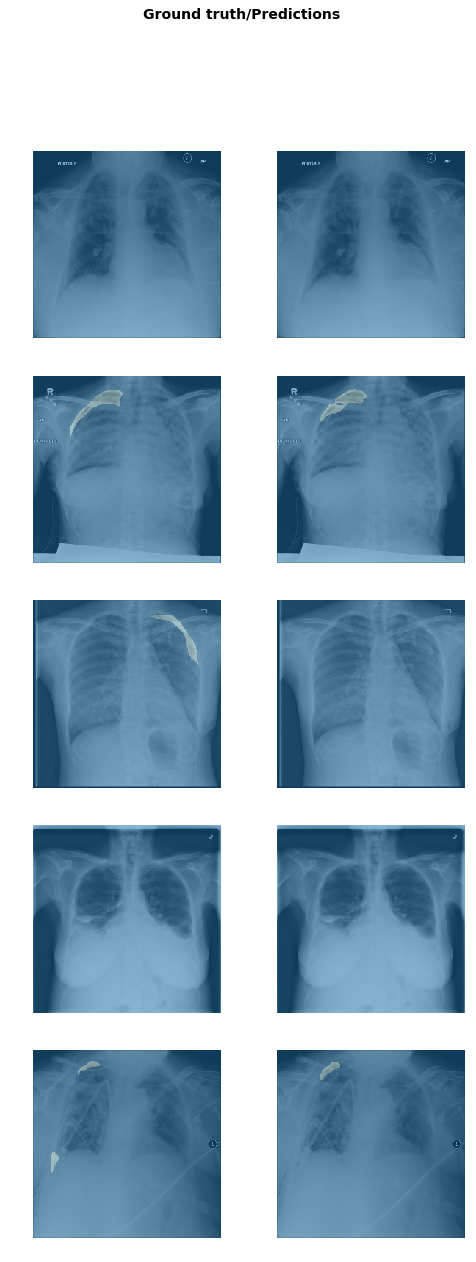

In [109]:
learner.show_results()

In [ ]:
torch.max(learner.get_preds[0])

In [112]:
test_list = (PneumoSegmentationList.
             from_folder(TEST_PATH, extensions=['.dcm']))
db.add_test(test_list, tfms=(), tfm_y=False)

In [58]:
learner.destroy()
learner = unet_learner(db, models[MODEL], pretrained=PRETRAINED, loss_func=URLoss(BCEDiceLoss(a=0.5, b=0.5, beta=0.7, smooth=0.1)), wd=WD, model_dir=MODELS_PATH, metrics=[partial(dice, smooth=0.1)])
learner.load(save_name)
learner = learner.to_fp16()

this Learner object self-destroyed - it still exists, but no longer usable


/work/stages/schwob/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type BCEDiceLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [71]:
sampler = RandomSampler(len(db.train_ds))

In [72]:
learner.data.train_dl = db.train_dl.new(shuffle=False, sampler=sampler)

In [114]:
preds, gt = learner.get_preds(DatasetType.Test)

In [115]:
torch.min(preds), torch.max(preds)

(tensor(-95.), tensor(8.3281))

In [116]:
preds = torch.sigmoid(preds)

In [117]:
torch.max(preds)

tensor(0.9998)

In [133]:
preds[preds.view(preds.shape[0],-1).sum(-1) < 75.0*4,...] = 0.0

In [135]:
torch.max(preds)

tensor(0.9998)

In [119]:
valid_preds, valid_gt = learner.get_preds(DatasetType.Valid)

In [120]:
valid_preds = torch.sigmoid(valid_preds)
torch.max(valid_preds)

tensor(0.9997)

In [134]:
valid_preds[valid_preds.view(valid_preds.shape[0],-1).sum(-1) < 75.0*4,...] = 0.0

In [122]:
#torch.max(valid_preds)

In [123]:
def dice_overall(preds, targs, thr):
    n = preds.shape[0]
    preds = (preds>thr).float().view(n, -1)
    targs = targs.view(n, -1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    return (2. * intersect / union).mean()

In [127]:
def get_best_thr(preds, gt, plot=True):
    thrs = np.arange(0.1, 1, 0.01)
    dices = []
    for i in tqdm(thrs):
        dices.append(dice_overall(preds, gt, thr=i).item())
    dices = np.array(dices)
    best_dice = dices.max()
    best_thr = thrs[dices.argmax()]
    
    if plot:
        plt.figure(figsize=(8,4))
        plt.plot(thrs, dices)
        plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
        plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
        plt.show()
    
    return best_thr

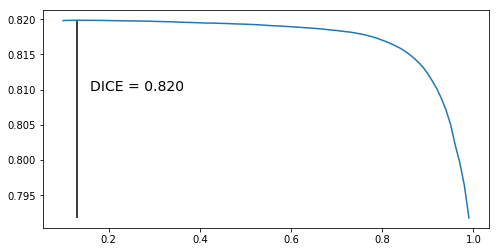

In [136]:
thr = get_best_thr(valid_preds, valid_gt)

In [137]:
thr

0.13

In [138]:
def create_submission(db, preds, path, thr=0.5):
    sub = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])
    index = 0
    for k, pred in tqdm(enumerate(preds.squeeze(1)), total=preds.size(0)):
        y = pred.numpy()
        y = cv2.resize(y, (1024, 1024), interpolation=cv2.INTER_CUBIC)
        labels = label(y > thr)
        id = db.test_ds.items[k].with_suffix('').name
        for i in range(1, labels.max()+1):
            mask = (labels == i).astype(np.uint8)*255
            if np.count_nonzero(mask) > 30:
                rle = mask2rle(mask.T, 1024, 1024)
                sub.loc[index] = [id, rle]
                index += 1
        if id not in sub['ImageId'].values:
            sub.loc[index] = [id, '-1']
            index += 1
    sub.to_csv(path, index=False)
    return sub

In [139]:
fn = '1_'+save_name+'.csv'
sub_df = create_submission(db, preds, SUB_PATH/fn, thr=thr)

In [167]:
(valid_preds>thr).unique(return_counts=True)

(tensor([0, 1], dtype=torch.uint8), tensor([52686222,     4722]))

In [140]:
!kaggle competitions submit -c siim-acr-pneumothorax-segmentation -f ../submissions/$fn -m "resnet34 with new params for loss func and almost blank masks zeroed out"

100%|█████████████████████████████████████████| 346k/346k [00:03<00:00, 109kB/s]
Successfully submitted to SIIM-ACR Pneumothorax Segmentation

In [61]:
learner.unfreeze()

In [171]:
learner.lr_find(num_it=200)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


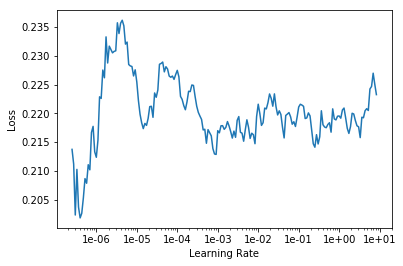

In [172]:
learner.recorder.plot(skip_end=1)

In [62]:
LR = 5e-4

In [63]:
uf_save_name = 'uf_'+save_name

In [64]:
learner.fit_one_cycle(
    20, slice(LR),
    callbacks=[
        SaveModelCallback(
            learner, monitor='dice', name=uf_save_name),
        UpdateSamplerCallback(learner),
        AccumulateStep(learner, 64//BATCH_SIZE)])

epoch,train_loss,valid_loss,dice,time


KeyboardInterrupt: 

In [ ]:
learner.recorder.plot_losses()

In [ ]:
learner.recorder.plot_metrics()

In [ ]:
learner.destroy()
learner = unet_learner(db, models[MODEL], pretrained=PRETRAINED, loss_func=URLoss(BCEDiceLoss(a=0.5, b=0.5, beta=0.7, smooth=0.1)), wd=WD, model_dir=MODELS_PATH, metrics=[partial(dice, smooth=0.1)])
learner.load(uf_save_name)
learner = learner.to_fp16()

In [ ]:
learner.show_results()

In [ ]:
preds, gt = learner.get_preds(DatasetType.Test)

In [ ]:
preds = torch.sigmoid(preds)

In [ ]:
preds[preds.view(preds.shape[0],-1).sum(-1) < 75.0*4,...] = 0.0

In [ ]:
valid_preds, valid_gt = learner.get_preds(DatasetType.Valid)

In [ ]:
valid_preds[valid_preds.view(valid_preds.shape[0],-1).sum(-1) < 75.0*4,...] = 0.0

In [ ]:
thr = get_best_thr(valid_preds, valid_gt)

In [ ]:
sub_df = create_submission(db, preds, SUB_PATH/(uf_save_name+'.csv'), thr=thr)

In [ ]:
!kaggle competitions submit -c siim-acr-pneumothorax-segmentation -f ../submissions/$(uf_save_name+'.csv') -m "test with resnet34 and zeroing small masks + unfrozen"

## K-fold

In [240]:
def load_data_kfold(path, nfolds=5, bs=8, train_size=256):
    kf = KFold(n_splits=nfolds, shuffle=True)
    train_list = (PneumoSegmentationList.
                  from_csv(path.parent, path.name))
    for _, valid_idx in kf.split(np.arange(len(train_list))):
        db = (train_list.
              split_by_idx(valid_idx).
              label_from_df(cols=[0, 1], classes=['pneum'], label_cls=MaskList, train_path=path.parent).
              transform(get_transforms(), size=train_size, tfm_y=True).
              databunch(bs=bs, num_workers=0).
              normalize(imagenet_stats))
        yield db

In [ ]:
best = 0
for k, db in enumerate(load_data_kfold(LABELS_POS, bs=BATCH_SIZE, train_size=TRAIN_SIZE)):
    print(f'fold {k}')
    
    learner = unet_learner(db, models[MODEL], pretrained=PRETRAINED,
                           loss_func=URLoss(BCEDiceLoss(a=0.7, b=0.3)), wd=WD, model_dir=MODELS_PATH, metrics=[dice])
    next(learner.model.children())[0].load_state_dict(torch.load(MODELS_PATH/clf_name))
    learner = learner.to_fp16()
    
    fold_name = f'fold{k}_'+save_name
    learner.fit_one_cycle(
        20, slice(LR),
        callbacks=[
            SaveModelCallback(
                learner, monitor='dice', name=fold_name),
            UpdateSamplerCallback(learner),
            AccumulateStep(learner, 64//BATCH_SIZE)])

    learner.load(fold_name)
    _, met = learner.validate()

    if met > best:
        learner.save(save_name)
        best = met
        print(f'New best fold {k} with dice {best}')
print(best)

fold 2


epoch,train_loss,valid_loss,dice,time


In [240]:
def predict_k_fold(db, save_name, test_path, nfolds=5, size=256):
    test_list = (PneumoSegmentationList.
                 from_folder(test_path, extensions=['.dcm']))
    db.add_test(test_list, tfms=(), tfm_y=False)
    learner = unet_learner(db, models[MODEL], pretrained=PRETRAINED,
                           loss_func=DiceLoss(), wd=WD, model_dir=MODELS_PATH, metrics=[dice])
    learner = learner.to_fp16()
    
    final_preds = torch.zeros((len(test_list), 1, size, size))
    
    for k in range(nfolds):
        learner.load(f'fold{k}_'+save_name)
        
        preds, gt = learner.get_preds(DatasetType.Test)
        preds = torch.sigmoid(preds)
        preds[preds.view(preds.shape[0],-1).sum(-1) < 75.0*4,...] = 0.0

        valid_preds, valid_gt = learner.get_preds(DatasetType.Valid)
        valid_preds[valid_preds.view(valid_preds.shape[0],-1).sum(-1) < 75.0*4,...] = 0.0
        thr = get_best_thr(valid_preds, valid_gt, plot=False)
        
        final_preds += (preds>thr).float()
    
    final_preds /= nfolds
    sub_df = create_submission(db, final_preds, SUB_PATH/(save_name+'.csv'), thr=0.9)
    return sub_df, final_preds

In [241]:
sub_df, preds = predict_k_fold(learner.data, save_name, TEST_PATH, size=TRAIN_SIZE)

In [243]:
test_list = (PneumoSegmentationList.
             from_folder(TEST_PATH, extensions=['.dcm']))
db = learner.data
db.add_test(test_list, tfms=(), tfm_y=False)
sub_df = create_submission(db, preds, SUB_PATH/('4_'+save_name+'.csv'), thr=0.9)

In [244]:
fn = '4_'+save_name+'.csv'
!kaggle competitions submit -c siim-acr-pneumothorax-segmentation -f ../submissions/$fn -m "test with resnet34 and k-fold"

100%|█████████████████████████████████████████| 500k/500k [00:04<00:00, 125kB/s]
403 - Your team has used its submission allowance (5 of 5). This resets at midnight UTC (15 hours from now).


# CLASSIF

In [241]:
db_clf, class_weights = load_data_classif(LABELS_CLASSIF, bs=BATCH_SIZE, train_size=TRAIN_SIZE, weight_sample=False)

In [242]:
clf = cnn_learner(db_clf, models[MODEL], pretrained=PRETRAINED,
                  loss_func=URLoss(nn.CrossEntropyLoss()),
                  wd=WD, model_dir=MODELS_PATH, metrics=[accuracy])

In [259]:
sampler = RandomSampler(len(db_clf.train_ds))

In [260]:
clf.data.train_dl = db_clf.train_dl.new(shuffle=False, sampler=sampler)

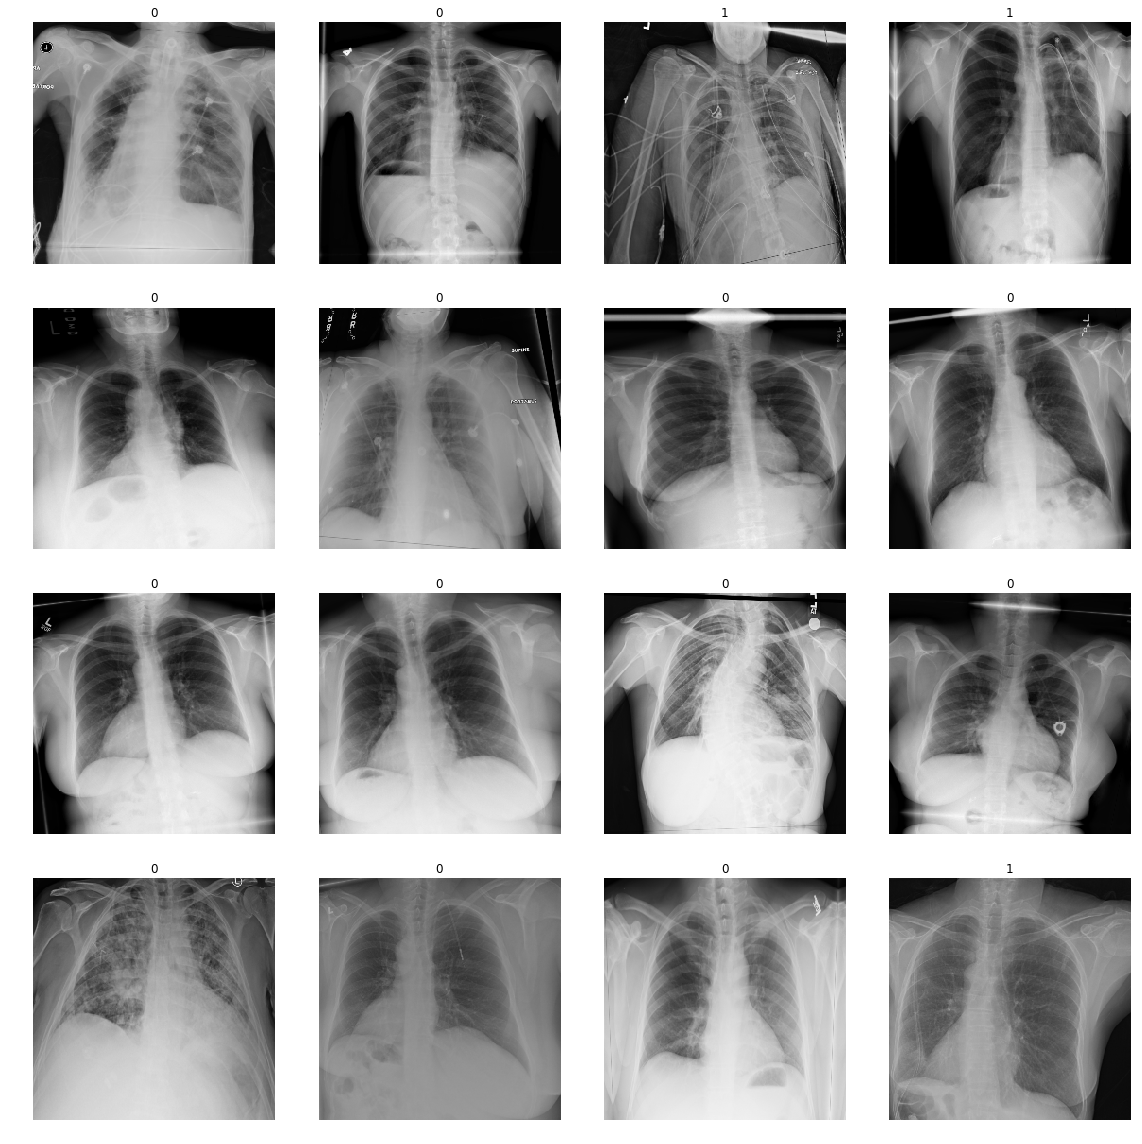

In [144]:
db_clf.show_batch(cmap=plt.cm.bone)

In [145]:
#clf.load('clf_resnet152_0').to_fp16()

In [245]:
clf = clf.to_fp16()

In [249]:
clf.unfreeze()

In [250]:
clf.lr_find(num_it=200)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


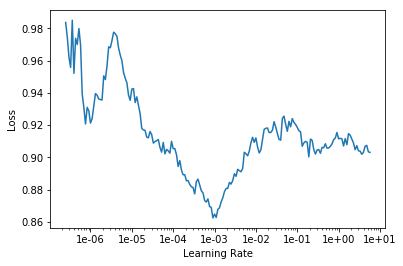

In [251]:
clf.recorder.plot()

In [248]:
save_name = f'clf_{MODEL}'
save_name = f'{save_name}_{getNextFilePath(MODELS_PATH, save_name)}'
save_name

'clf_resnet50_1'

In [252]:
set_BN_momentum(clf.model)

In [261]:
clf.fit_one_cycle(
    10, slice(2e-4),
    callbacks=[
        SaveModelCallback(
            clf, monitor='accuracy', name=save_name),
        UpdateSamplerCallback(clf),
        AccumulateStep(clf, 64//BATCH_SIZE)])

epoch,train_loss,valid_loss,accuracy,time
0,0.725017,0.558861,0.705386,04:51
1,0.639821,0.463212,0.787354,05:08
2,0.590678,0.452474,0.790164,05:34
3,0.579116,0.422959,0.810773,05:14
4,0.567244,0.377163,0.828571,05:05
5,0.528146,0.376522,0.833255,05:06
6,0.547187,0.372137,0.831382,05:07
7,0.524315,0.352877,0.844496,05:15
8,0.517686,0.346703,0.853396,05:05
9,0.533199,0.346201,0.853864,05:12


Better model found at epoch 0 with accuracy value: 0.7053864002227783.
Better model found at epoch 1 with accuracy value: 0.7873536348342896.
Better model found at epoch 2 with accuracy value: 0.7901639342308044.
Better model found at epoch 3 with accuracy value: 0.8107728362083435.
Better model found at epoch 4 with accuracy value: 0.8285714387893677.
Better model found at epoch 5 with accuracy value: 0.8332552909851074.
Better model found at epoch 7 with accuracy value: 0.844496488571167.
Better model found at epoch 8 with accuracy value: 0.8533957600593567.
Better model found at epoch 9 with accuracy value: 0.8538641929626465.


(0.0, 650.0)

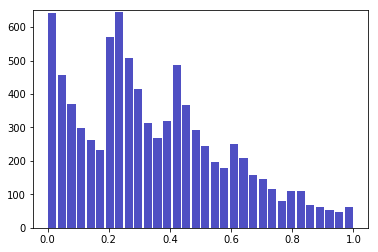

In [262]:
w = clf.data.train_dl.sampler.weights.detach().numpy()
n, bins, patches = plt.hist(x=w, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(top=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

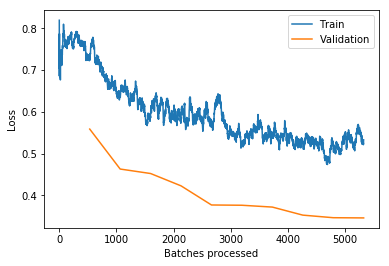

In [263]:
clf.recorder.plot_losses()

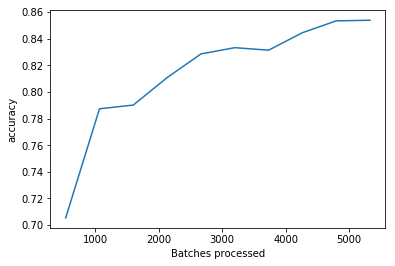

In [264]:
clf.recorder.plot_metrics()

In [103]:
clf.unfreeze()

In [104]:
clf.fit_one_cycle(
    10, slice(LR/100, LR/5),
    callbacks=[
        SaveModelCallback(
            clf, monitor='accuracy', name='clf_resnet34_0')])

epoch,train_loss,valid_loss,accuracy,time
0,0.331760,0.539473,0.848712,04:10
1,0.417100,0.494817,0.825293,04:05
2,0.369095,0.462193,0.850585,04:05
3,0.368526,0.452364,0.845902,04:11
4,0.321620,0.401773,0.851054,04:15
5,0.284002,0.450151,0.862763,04:26
6,0.269790,0.379925,0.873068,04:27
7,0.219583,0.390562,0.865574,04:18
8,0.193927,0.376994,0.861358,04:20
9,0.195821,0.387272,0.866042,04:18


Better model found at epoch 0 with accuracy value: 0.8487119674682617.
Better model found at epoch 2 with accuracy value: 0.8505854606628418.
Better model found at epoch 4 with accuracy value: 0.8510538935661316.
Better model found at epoch 5 with accuracy value: 0.8627634644508362.
Better model found at epoch 6 with accuracy value: 0.8730679154396057.


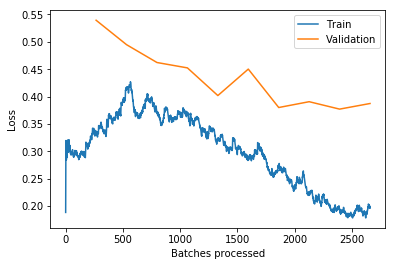

In [106]:
clf.recorder.plot_losses()

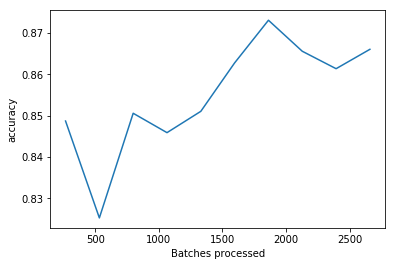

In [107]:
clf.recorder.plot_metrics()

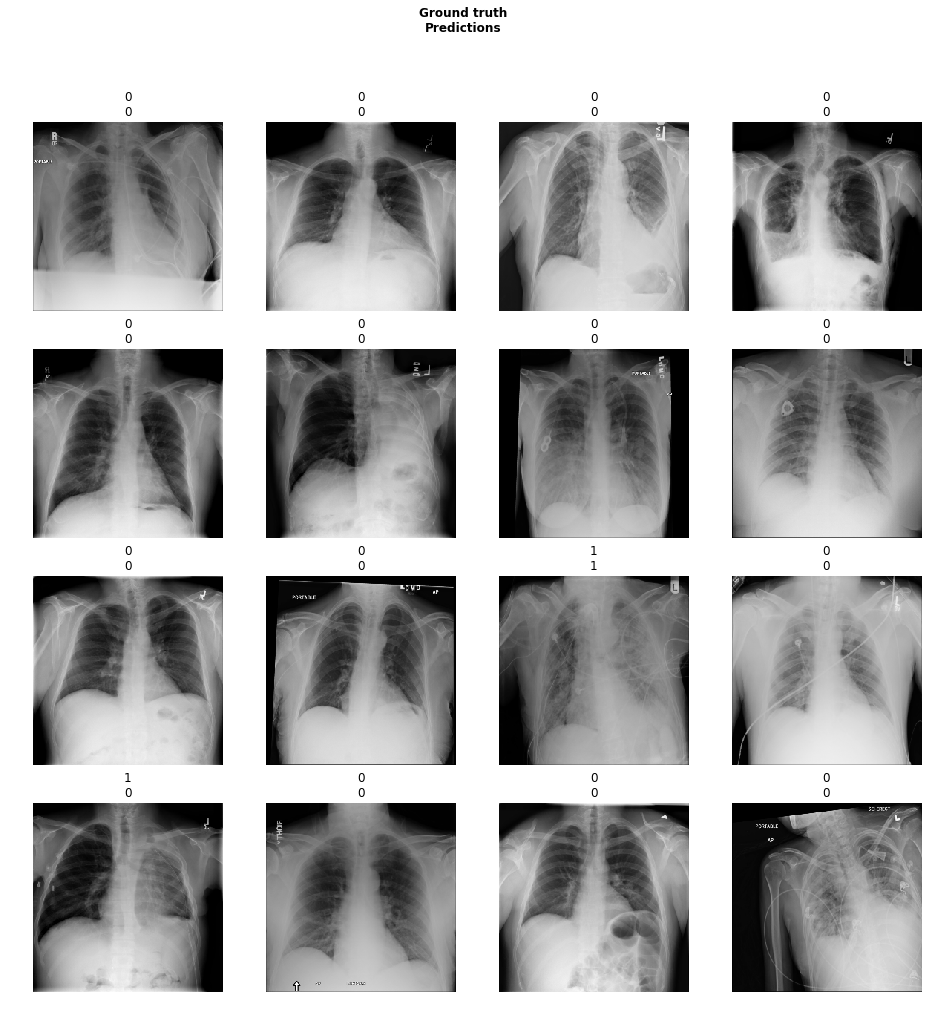

In [133]:
clf.show_results()

In [265]:
interp = clf.interpret()

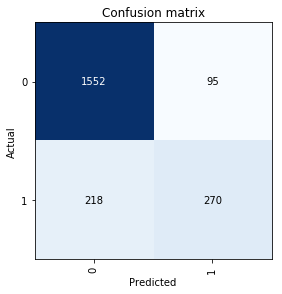

In [266]:
interp.plot_confusion_matrix()

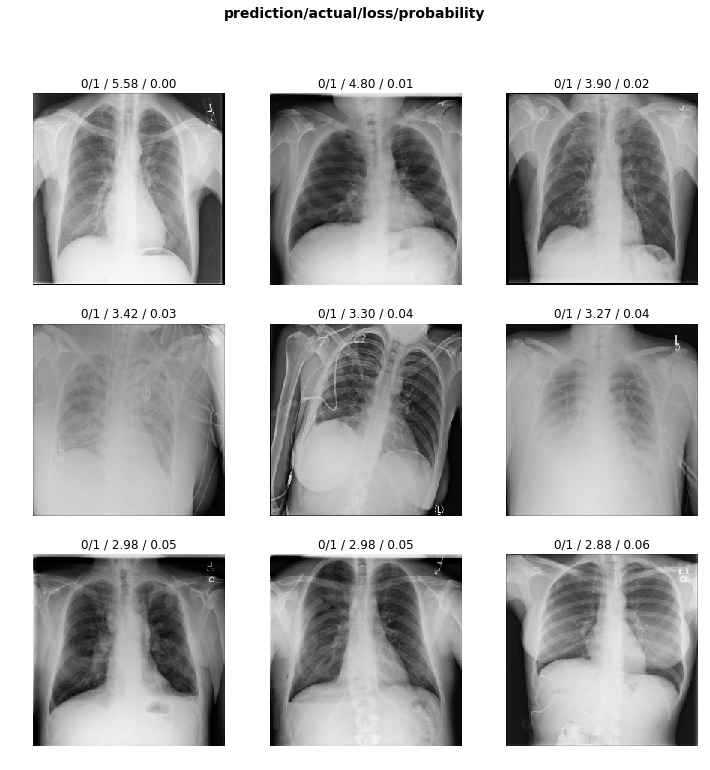

In [267]:
interp.plot_top_losses(9, heatmap=False)

In [268]:
torch.save(next(clf.model.children()).state_dict(), MODELS_PATH/f'backbone_{save_name}.pth')

In [269]:
clf.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [307]:
df = pd.read_csv(LABELS_CLASSIF)
stats = pd.DataFrame(columns=['ImageId', 'Age', 'Sex', 'Height', 'Width', 'Pneumo'])
for row in tqdm(df.itertuples(), total=df.shape[0]):
    fn = row.ImageId
    ds = pydicom.dcmread(str(DATA/fn))
    h, w = ds.pixel_array.shape
    stats.loc[row.Index] = [row.ImageId, int(ds.PatientAge), ds.PatientSex, h, w, int(row.Labels)]

In [308]:
stats.head()

,ImageId,Age,Sex,Height,Width,Pneumo
0,train/1.2.276.0.7230010.3.1.4.8323329.5597.151...,51,F,1024,1024,0
1,train/1.2.276.0.7230010.3.1.4.8323329.12515.15...,17,F,1024,1024,0
2,train/1.2.276.0.7230010.3.1.4.8323329.4904.151...,69,F,1024,1024,1
3,train/1.2.276.0.7230010.3.1.4.8323329.32579.15...,57,F,1024,1024,1
4,train/1.2.276.0.7230010.3.1.4.8323329.1314.151...,16,M,1024,1024,1


In [36]:
stats.loc[stats['Sex']=='F'].shape[0]

4795

In [37]:
stats.loc[stats['Sex']=='M'].shape[0]

5880

In [313]:
stats_age = stats.groupby(pd.cut(stats['Age'], list(range(0, 101, 10))+[450]))

In [39]:
stats_age.count()['Pneumo']

Age
(0, 10]        135
(10, 20]       674
(20, 30]      1266
(30, 40]      1498
(40, 50]      2059
(50, 60]      2606
(60, 70]      1769
(70, 80]       600
(80, 90]        65
(90, 100]        1
(100, 450]       2
Name: Pneumo, dtype: int64

In [309]:
stats_age.sum()['Pneumo']/stats_age.count()['Pneumo']

Age
(0, 10]       0.074074
(10, 20]      0.330861
(20, 30]      0.256714
(30, 40]      0.197597
(40, 50]      0.206897
(50, 60]      0.208749
(60, 70]      0.220464
(70, 80]      0.243333
(80, 90]      0.292308
(90, 100]     0.000000
(100, 450]    0.000000
Name: Pneumo, dtype: float64

In [314]:
stats_sex = stats.groupby('Sex')

In [314]:
stats_sex.count()['Pneumo']

Sex
F    4795
M    5880
Name: Pneumo, dtype: int64

In [313]:
stats_sex.sum()['Pneumo']/stats_sex.count()['Pneumo']

Sex
F    0.219604
M    0.225510
Name: Pneumo, dtype: float64

In [303]:
losses, idxs = interp.top_losses()

In [304]:
idxs = idxs.numpy()

In [305]:
ids = []
for i, l in zip(idxs, losses):
    if l.item()<0.2:
        break
    id = Path(interp.ds.items[i])
    id = Path(id.parent.name)/id.name
    ids.append(str(id))

In [309]:
top_losses = stats.loc[stats['ImageId'].isin(ids)]

In [310]:
top_losses.head()

,ImageId,Age,Sex,Height,Width,Pneumo
7,train/1.2.276.0.7230010.3.1.4.8323329.4440.151...,65,F,1024,1024,1
44,train/1.2.276.0.7230010.3.1.4.8323329.13361.15...,52,F,1024,1024,1
52,train/1.2.276.0.7230010.3.1.4.8323329.14508.15...,21,M,1024,1024,1
70,train/1.2.276.0.7230010.3.1.4.8323329.4333.151...,58,M,1024,1024,1
79,train/1.2.276.0.7230010.3.1.4.8323329.3140.151...,62,F,1024,1024,1


In [311]:
top_losses.groupby('Pneumo').count().head()['ImageId']

Pneumo
0     73
1    191
Name: ImageId, dtype: int64

In [315]:
top_losses.groupby('Sex').count().head()['ImageId']/stats_sex.count()['Pneumo']

Sex
F    0.022941
M    0.026190
dtype: float64

In [316]:
top_losses.groupby(pd.cut(top_losses['Age'], list(range(0, 101, 10))+[450])).count().head()['ImageId']/stats_age.count()['Pneumo']

Age
(0, 10]       0.022222
(10, 20]      0.025223
(20, 30]      0.033175
(30, 40]      0.022029
(40, 50]      0.019427
(50, 60]           NaN
(60, 70]           NaN
(70, 80]           NaN
(80, 90]           NaN
(90, 100]          NaN
(100, 450]         NaN
dtype: float64

In [112]:
dl = clf.data.train_dl

In [167]:
from itertools import tee
def new_iter(self):
    dl = iter(self.dl)
    dl.sample_iter, self.sample_iter = tee(dl.sample_iter)
    for b in dl:
        yield self.proc_batch(b)

In [168]:
from fastai.basic_data import DeviceDataLoader
DeviceDataLoader.__iter__= new_iter

In [208]:
idxs = []
xs = []
for x in tqdm(dl, total=len(dl)):
    idxs.append(next(dl.sample_iter))
    xs.append(x)

False



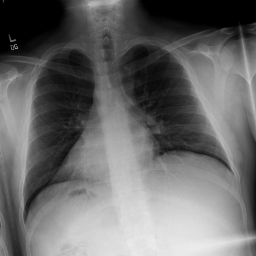

In [220]:
clf.data.train_ds[idxs[2][0]][0]

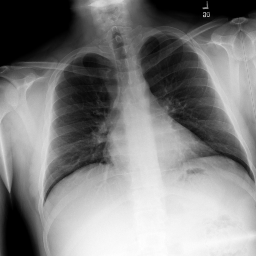

In [221]:
x = xs[2][0][0].float()
Image((x-torch.min(x))/(torch.max(x)-torch.min(x)))

In [207]:
next(iter(dl))

False


[tensor([[[[-1.7305e+00, -1.7314e+00, -1.7324e+00,  ...,  1.4130e-02,
            -6.0156e-01, -5.4541e-01],
           [-1.7549e+00, -1.7314e+00, -1.7383e+00,  ...,  7.9150e-01,
            -6.6016e-01, -5.1807e-01],
           [-1.7461e+00, -1.7471e+00, -1.7461e+00,  ...,  1.2373e+00,
            -4.7974e-01, -3.7573e-01],
           ...,
           [-8.3203e-01, -7.8516e-01, -6.3135e-01,  ..., -2.1033e-01,
            -3.0688e-01, -4.8975e-01],
           [-9.5850e-01, -8.4424e-01, -7.4658e-01,  ..., -2.3035e-01,
            -3.6426e-01, -5.3955e-01],
           [-1.0410e+00, -9.2822e-01, -8.0859e-01,  ..., -2.2888e-01,
            -3.6890e-01, -5.4395e-01]],
 
          [[-1.7305e+00, -1.7314e+00, -1.7324e+00,  ...,  1.4130e-02,
            -6.0156e-01, -5.4541e-01],
           [-1.7549e+00, -1.7314e+00, -1.7383e+00,  ...,  7.9150e-01,
            -6.6016e-01, -5.1807e-01],
           [-1.7461e+00, -1.7471e+00, -1.7461e+00,  ...,  1.2373e+00,
            -4.7974e-01, -3.7573e-01],
